In [1]:
using Revise

In [2]:
push!(LOAD_PATH, "/home/amir/work/mps/src/")

using KrylovKit
using SparseArrays
using LinearAlgebra
using Plots
using LaTeXStrings
using FFTW
using LsqFit

using QuantumModels
using MatrixProductStateTools
using ExactDiagonalizationTools
using SymTensors
using GaussianFermions
using GutzwillerMPS

┌ Info: Precompiling ExactDiagonalizationTools [top-level]
└ @ Base loading.jl:1273
┌ Info: Precompiling GutzwillerMPS [top-level]
└ @ Base loading.jl:1273


[-0.8914767115530771, -0.5473259801441659, -0.18453671892660473, 0.18453671892660406, 0.5473259801441659]


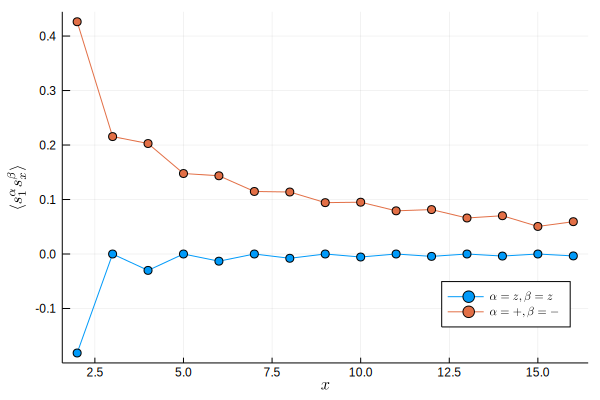

In [14]:
lx=16
L = 1 * lx
m = 50
hamil = generatebdg(triangularhopping((1,lx), 1.0, 1., 1., 1., boundary=(:OBC, :OBC)))
cm = correlationmatrix(hamil, div(L,2))
fgs = generate_fishmangates(cm)
mps = fishman2mps(fgs, m, symmetry=:U1)

sz, sp, sm = spinoperators(1/2, symmetry=:U1)

fhop_pm = measure_2point(mps, sp, sm)
#fhop_mp = measure_2point(mps, sm, sp)
fhop_zz = measure_2point(mps, sz, sz)
indexes = [half_measurement_index(lx,1,l+1) for l=1:lx-1]

p = plot(xaxis=(L"$x$"), yaxis=(L"$\langle s^\alpha_1 s^\beta_x\rangle$"), legend=:bottomright)
plot!(p, [2:lx], fhop_zz[indexes], marker=(:circle), label=L"\alpha=z, \beta=z")
plot!(p, [2:lx], fhop_pm[indexes], marker=(:circle), label=L"\alpha=+, \beta=-")
#plot!(p, [2:lx], fhop_mp[indexes], marker=(:circle), label=L"\alpha=-, \beta=+")

In [19]:
mps1 = mps
mps2 = mps

move_center!(mps1, 1)
move_center!(mps2, 1)

In [42]:
A = mps1.matrices[16]
isrightisometry(SymMatrix(fuselegs(A, -1, 2, 2)))

true

In [72]:
dims = ones(Int64, lx+1)
matrices = SymTensor{Float64, 3}[]

## NOTE: in order to make the gutzwiller projector respect the U1
## symmetry we need to do the follwoing. Assume the first mps
## corresponds to ↑ or 1 and second mps to ↓ or -1.
 G = fill(one(Float64), 0,
         (STLeg(+1, [-1,1], [1,1]),
          STLeg(-1, [0,1], [1,1]),
          STLeg(+1, [0,1], [1,1])))

for l=1:lx
    A = mps1.matrices[l]
    B = invlegs(mps2.matrices[l])

    fswap = fermionswapgate(A.legs[2], B.legs[1])
    ##NOTE:
    # contracting (E2, A1)
    # First tensor has EA = E1 E3 A2 A3
    # contracting with swap
    # second tensor has EAX = E1 A2 E3 A3
    # contracting (A2, G2)
    # Third tensor has EAG = E1 G1 G3 E3 A3
    # contracting (E3, B1) and (G3, B2)
    # Final tensor has E1 G1 A3 B3
    C = contract(contract(contract(A, (1, -1, 5), fswap, (2, 3, 4, -1)),
                          (1, 2, -1, 5, 6), G, (3, -1, 4)),
                 (1,2, 3,-2, -1,5), B, (-1,-2, 4))

    @show C.sects
    Cmps = fuselegs(fuselegs(C, +1, 1, 2), -1, 3, 2)
    trimleg!(Cmps, 1)
    trimleg!(Cmps, 3)
#     if l==2
#         for i in eachindex(Cmps.sects)
#             println(" Sector $i")
#             println(Cmps.sects[i])
#             println(Cmps.nzblks[i])
#             println()
#         end
#     end
#     @show Cmps.legs
    dims[l+1] = size(A, 3) * size(B, 3)

    fnl = x->div(x+l-1, 2)
    fnd = x->div(x+1, 2)
    fnr = x->div(x+l, 2)
    push!(matrices, mapcharges((fnl,fnd,fnr), Cmps))
end

C.sects = NTuple{5,Int64}[(0, 0, -1, 1, 0), (0, 0, 1, 0, 1)]
C.sects = NTuple{5,Int64}[(1, 0, -1, 0, 0), (0, 1, 1, 0, 0), (0, 0, -1, 1, 0), (1, 1, -1, 1, 0), (0, 1, -1, 2, 0), (0, 0, 1, 0, 1), (1, 1, 1, 0, 1), (1, 0, -1, 1, 1), (0, 1, 1, 1, 1), (0, 0, -1, 2, 1), (1, 1, -1, 2, 1), (1, 0, 1, 0, 2), (0, 0, 1, 1, 2), (1, 1, 1, 1, 2), (1, 0, -1, 2, 2), (0, 1, 1, 2, 2)]


ErrorException: mapping charges creates duplicates! [-1, 0, 1] -> [0, 0, 1]

MethodError: MethodError: no method matching isleftisometry()
Closest candidates are:
  isleftisometry(!Matched::SymMatrix) at /home/amir/work/mps/src/symtools.jl:95